In [179]:
# import a custom plotting library
import some_plotters as plotter
import matplotlib.pyplot as plt

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload functi"on - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

#Other Imports
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 2: </span>  Imitation Learning on the two-tank problem 

In this exercise you will create a system model - using a small snippet of data for the two-tank problem outlined in the [course notes](https://github.com/jermwatt/control-notes).  This comes from a real life two-tanks experiment - the amount of water allowed into the top tank (per second) - the action sequence $a_t$ - is shown as the black curve in the bottom panel.  In the top panel the *upper* tank water level $s_{1,t}$ is shown in green, and the bottom tank level $s_{2,t}$ is shown in magenta.

/home/chris/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


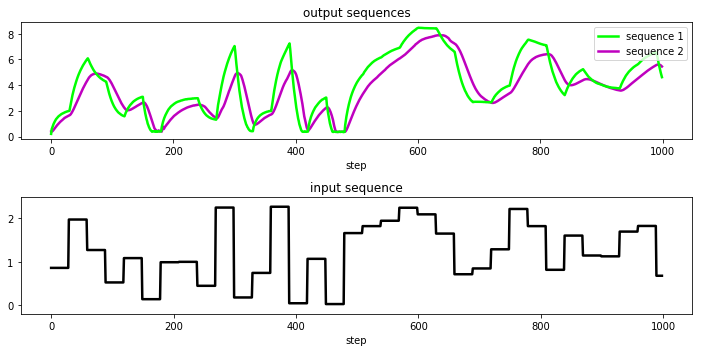

(2, 1000)

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# load series
data = np.loadtxt(datapath + 'cascaded_tanks_1.csv',delimiter = ',')
actions = data[0:1,1:]
states = data[1:,:]
# plot the test pair
plotter.plot_3fer(actions,states[0],states[1],plot_type = 'continuous')

This system has two $s_{1,t}$ and $s_{2,t}$, hence the Imitator consists of an equation for each.  The upper tank level $s_{1,t}$ is dependent on its own history and - of course- the amount of water $a_t$ that is poured into it.  A simple linear model for this looks like

\begin{equation}
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t.
\end{equation}

Since we know that the upper tank drains into the lower one, the simplest sort of system model we can make for the lower tank level $s_{2,t}$ is that it is proportional to its prior value and that of the upper tank, as

\begin{equation}
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{equation}

Together - using the simplest model for this system we could think of - we have the following two system model equations

\begin{array}
\
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t \\
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{array}

Tune the parameters of this system model $w_0$ through $w_5$ via minimizing a Least Squares cost function so that your imitator learns to mimic the *second tank level* ($s_{2,t}$) - the magenta curve above.

Use the data shown above for training (i.e., you need not cut off a chunk of it for validation - use it all for training).  

Make sure to plot the fit your model provides on the training data.  You can see this exact system model fit to this exact dataset in the course notes - make sure your fit looks fairly similar.

Your result should look something like the one below - shown in dashed black.

<figure>
<p>
<img src= 'images/bottom_tank_approximate.png' width="150%" height="150%" alt=""/>
</p>
</figure>

In [100]:
#pull the gradient descent function from the helper functions notebook
def gradient_descent(g,w_init,alpha,max_its,verbose): 
    # flatten the input function
    g_flat, unflatten, w = flatten_func(g, w_init)
    
    # compute gradient of flattened input function
    # when evaluated this returns both the evaluation of the gradient and the original function
    grad = value_and_grad(g_flat)
    cost_eval,grad_eval = grad(w)
    grad_eval.shape = np.shape(w)

    # record history
    w_hist = [unflatten(w)]
    train_hist = [cost_eval]
        
    # gradient descent loop
    for k in range(max_its): 
        # take descent step with momentum
        w = w - alpha*grad_eval
        
        # plug in updated w into func and gradient
        cost_eval,grad_eval = grad(w)
        grad_eval.shape = np.shape(w)
                
        # store updates
        w_hist.append(unflatten(w))
        train_hist.append(cost_eval)

        # print update
        if verbose == True:
            print ('step ' + str(k+1) + ' complete, train cost = ' + str(np.round(train_hist[-1],4)[0]))

    # print update and return
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
    return w_hist,train_hist

In [101]:
# standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [161]:
#Define the model as set above
def model(s1,s2,a,w):
    s1_t = w[0] + s1*w[1] + a*w[2]
    s2_t = w[3] + s2*w[4] + s1*w[5]
    return s1_t, s2_t

#Define the least squares cost function
def least_squares(s,a,w):
    s1 = s[0,:]
    s2 = s[1,:]
    T = len(s1)
    #S1
    s_t1  = s1[0:T-1]
    s_tp1 = s1[1:T]
    #S2
    s_t2  = s2[0:T-1]
    s_tp2 = s2[1:T]
    #Run the model
    s1p,s2p = model(s_t1,s_t2,a.T,w)
    #Error for both cost functions
    err1 = (s1p - s_tp1)**2
    err2 = (s2p - s_tp2)**2
    #Return the total error
    return (np.sum(err1)+np.sum(err2))/T-1

In [162]:
#Seperate training and validation data using 70/30 rule
#Note the state vector is one longer than the action vector - we need s[t_end+1] for the last step, remember
states_train = states[:,0:700]
actions_train = actions[:,0:699].T

states_valid = states[:,701:len(states.T)]
actions_valid = actions[:,700:len(actions.T)]

In [163]:
#Normalize the data for training by first, grabbing the functions/inv functions and second, actually normalizing

#Grab state, action normalization/inv norm. functions
state_norm, state_inv_norm = standard_normalizer(states_train)
action_norm, action_inv_norm = standard_normalizer(actions_train.T)

#Normalize state-actions
actions_train_normalized = action_norm(actions_train)
states_train_normalized = state_norm(states_train)

3.8570064448891541

In [223]:
#Gradient Descent Params 
w_init = np.random.randn(6,1)
alpha = 10**-2
max_its = 1000
verbose = True

#Make an instance of Least Squares with the data locked in
g = lambda w, a = actions_train_normalized, s = states_train_normalized: least_squares(s,a,w)

#Run gradient descent 
whx,thx = gradient_descent(g, w_init, alpha, max_its, verbose)

step 1 complete, train cost = 9.2958
step 2 complete, train cost = 8.6256
step 3 complete, train cost = 8.0
step 4 complete, train cost = 7.416
step 5 complete, train cost = 6.8709
step 6 complete, train cost = 6.3621
step 7 complete, train cost = 5.887
step 8 complete, train cost = 5.4436
step 9 complete, train cost = 5.0296
step 10 complete, train cost = 4.6431
step 11 complete, train cost = 4.2822
step 12 complete, train cost = 3.9453
step 13 complete, train cost = 3.6307
step 14 complete, train cost = 3.3369
step 15 complete, train cost = 3.0626
step 16 complete, train cost = 2.8065
step 17 complete, train cost = 2.5673
step 18 complete, train cost = 2.3438
step 19 complete, train cost = 2.1352
step 20 complete, train cost = 1.9403
step 21 complete, train cost = 1.7583
step 22 complete, train cost = 1.5882
step 23 complete, train cost = 1.4294
step 24 complete, train cost = 1.281
step 25 complete, train cost = 1.1423
step 26 complete, train cost = 1.0128
step 27 complete, train cos

step 267 complete, train cost = -0.9666
step 268 complete, train cost = -0.9668
step 269 complete, train cost = -0.967
step 270 complete, train cost = -0.9672
step 271 complete, train cost = -0.9674
step 272 complete, train cost = -0.9676
step 273 complete, train cost = -0.9678
step 274 complete, train cost = -0.968
step 275 complete, train cost = -0.9682
step 276 complete, train cost = -0.9684
step 277 complete, train cost = -0.9686
step 278 complete, train cost = -0.9688
step 279 complete, train cost = -0.969
step 280 complete, train cost = -0.9692
step 281 complete, train cost = -0.9694
step 282 complete, train cost = -0.9695
step 283 complete, train cost = -0.9697
step 284 complete, train cost = -0.9699
step 285 complete, train cost = -0.9701
step 286 complete, train cost = -0.9703
step 287 complete, train cost = -0.9705
step 288 complete, train cost = -0.9706
step 289 complete, train cost = -0.9708
step 290 complete, train cost = -0.971
step 291 complete, train cost = -0.9712
step

step 500 complete, train cost = -0.9907
step 501 complete, train cost = -0.9907
step 502 complete, train cost = -0.9908
step 503 complete, train cost = -0.9908
step 504 complete, train cost = -0.9909
step 505 complete, train cost = -0.9909
step 506 complete, train cost = -0.991
step 507 complete, train cost = -0.991
step 508 complete, train cost = -0.991
step 509 complete, train cost = -0.9911
step 510 complete, train cost = -0.9911
step 511 complete, train cost = -0.9912
step 512 complete, train cost = -0.9912
step 513 complete, train cost = -0.9913
step 514 complete, train cost = -0.9913
step 515 complete, train cost = -0.9913
step 516 complete, train cost = -0.9914
step 517 complete, train cost = -0.9914
step 518 complete, train cost = -0.9915
step 519 complete, train cost = -0.9915
step 520 complete, train cost = -0.9915
step 521 complete, train cost = -0.9916
step 522 complete, train cost = -0.9916
step 523 complete, train cost = -0.9917
step 524 complete, train cost = -0.9917
ste

step 765 complete, train cost = -0.9969
step 766 complete, train cost = -0.997
step 767 complete, train cost = -0.997
step 768 complete, train cost = -0.997
step 769 complete, train cost = -0.997
step 770 complete, train cost = -0.997
step 771 complete, train cost = -0.997
step 772 complete, train cost = -0.997
step 773 complete, train cost = -0.997
step 774 complete, train cost = -0.997
step 775 complete, train cost = -0.9971
step 776 complete, train cost = -0.9971
step 777 complete, train cost = -0.9971
step 778 complete, train cost = -0.9971
step 779 complete, train cost = -0.9971
step 780 complete, train cost = -0.9971
step 781 complete, train cost = -0.9971
step 782 complete, train cost = -0.9971
step 783 complete, train cost = -0.9971
step 784 complete, train cost = -0.9971
step 785 complete, train cost = -0.9971
step 786 complete, train cost = -0.9972
step 787 complete, train cost = -0.9972
step 788 complete, train cost = -0.9972
step 789 complete, train cost = -0.9972
step 790 

In [251]:
#Find the best of the weights
ind = np.argmin(thx)
w_best = whx[ind]
gbest = thx[ind]
#Print the best cost and the best weights
print("--Best Cost--")
print(gbest)
print("--Best Weights--")
print(w_best)

--Best Cost--
[-0.9983763]
--Best Weights--
[[ 0.00152239]
 [ 0.94360674]
 [ 0.0743404 ]
 [ 0.00190348]
 [ 0.88565988]
 [ 0.12156404]]


-- Mean of Squared Error --
5.19618028507e-06


<IPython.core.display.Javascript object>


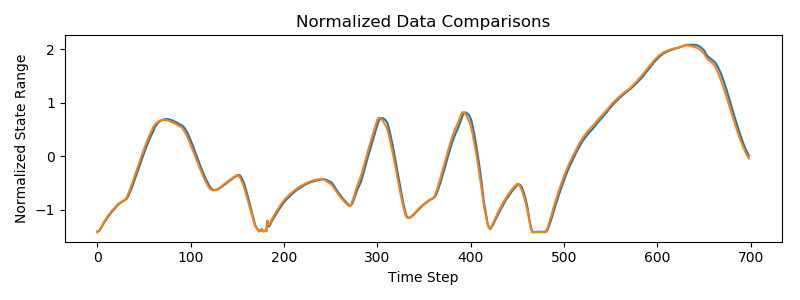

In [253]:
#Test the model with normalized data  - this is for testing 
out1,out2 = model(states_train_normalized[0,0:699],states_train_normalized[1,0:699],actions_train_normalized.T, w_best)

a = states_train_normalized[1,0:699]
b = actions_train
err = out2 - a
print("-- Mean of Squared Error --")
print(np.mean(err**2)/len(err))
plt.figure(num=1,figsize = (8,3))
plt.title("Normalized Data Comparisons")
plt.xlabel("Time Step")
plt.ylabel("Normalized State Range")
plt.plot(a)
plt.plot(out2)

<IPython.core.display.Javascript object>


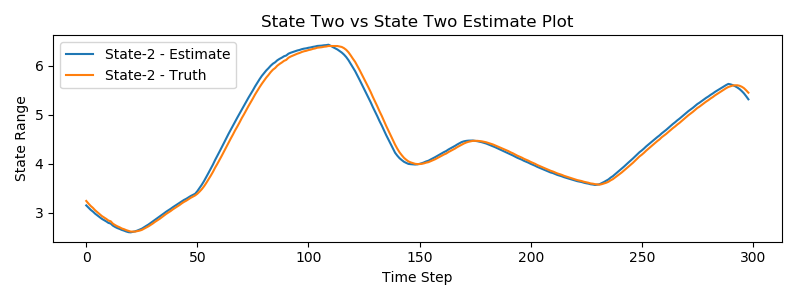

In [291]:
# ---- SOLUTION ---- 
#Validation set(reminder, this is prealloc.)
states_valid = states[:,701:len(states.T)]
actions_valid = actions[:,700:len(actions.T)]

#Normalize state-actions
states_valid_normalized = state_norm(states_valid)
actions_valid_normalized = action_norm(actions_valid)

#Run the model with the normalized data to grab the states
#based on the model
state_est_norm_1,state_est_norm_2 = model(states_valid_normalized[0,0:299],states_valid_normalized[1,0:299],actions_valid_normalized, w_best)

#Unnormalize the second state
state_est_unnormed_2 = state_inv_norm(state_est_norm_2)

#Since the unnorm function considers two vectors... we pull just the one that's NON ZERO
state_est_unnormed_2 = state_est_unnormed_2[1,:]

#Plot Labels and Setup
plt.figure(num=2,figsize = (8,3))
plt.title("State Two vs State Two Estimate Plot")
plt.xlabel("Time Step")
plt.ylabel("State Range")
#Plot the unnormalized state estimates
plt.plot(state_est_unnormed_2)

#Plot the input states
plt.plot(states_valid[1,:].T)

#Legend and Display
plt.legend(["State-2 - Estimate", "State-2 - Truth"])
plt.show()

Since the estimate follows the data quite accurately (with a minor lag, it seems), it can be stated that the model is able to accurately track the second state and provide reasonable estimates. 